In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import KFold
from sklearn import linear_model, metrics, preprocessing
from sklearn.model_selection import KFold, train_test_split
import xgboost

import azureml.core
from azureml.core import Dataset
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

import sys
sys.path.append('../')
sys.path.append('../scripts/')
warnings.filterwarnings('ignore')
from pipeline import IndianModel, validate_on_holdout

In [2]:
# Log In to Azure ML Workspace
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")

# Initialise workspace
ws = Workspace.from_config(auth=interactive_auth)

# Data import 
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
data = aml_dataset.to_pandas_dataframe()
data.set_index('CardHolder', inplace=True)

# Save it to the further opeartions
original_columns = data.columns
data_origin = data.copy()

In [3]:
from importlib import reload
import features.functions
reload(features.functions)

# data = features.functions.preprocessing(data)
data_w_features = data.copy()

In [43]:
index_columns = ['gender', 'main_format', 'children']
data = data_w_features.copy()

# Let's fill NaN in "index_columns"
data.loc[:, 'group'].replace({'test' : 1, 'control' : 0}, inplace=True)
data.loc[:,'gender'].replace({'М' : 2, 'Ж' : 1, 'Не определен' : 0, None : 0}, inplace=True)
data.loc[:,'children'].replace({None : -1}, inplace=True)

In [44]:
from scripts.metrics import custom_metric
import features.functions
reload(features.functions)

data = data.reset_index().drop('CardHolder', axis=1)
data.loc[:, 'group'].replace({1 : 'test', 0 : 'control'}, inplace=True)

data['class'] = 0
data.loc[(data['group'] == 'control') & (data['response_att'] == 1), 'class'] = 1
data.loc[(data['group'] == 'test') & (data['response_att'] == 0), 'class'] = 2
data.loc[(data['group'] == 'test') & (data['response_att'] == 1), 'class'] = 3

In [101]:
cool_features = ['response_sms', 'k_var_days_between_visits_15d', 'response_viber',
                'k_var_days_between_visits_1m', 'k_var_days_between_visits_3m',
                'perdelta_days_between_visits_15_30d', 'stdev_discount_depth_1m',
                'stdev_days_between_visits_15d', 'cheque_count_6m_g48', 'cheque_count_12m_g48',
                'k_var_disc_share_3m_g34', 'cheque_count_6m_g40', 'k_var_discount_depth_15d',
                'crazy_purchases_goods_count_12m', 'sale_count_12m_g49', 'cheque_count_12m_g46',
                'k_var_count_per_cheque_3m_g34', 'cheque_count_6m_g32', 'cheque_count_6m_g41',
                'k_var_cheque_15d', 'class',
                'sale_sum_6m_g44', 'cheque_count_6m_g20']

data2 = data[cool_features + ['group', 'response_att']]

def magic_f(data, set_):
    a, b, c = set_
    return np.sqrt(data[a]**2 + data[b]**2 + data[c]**2)

e = ('sale_sum_6m_g44',
  'cheque_count_6m_g20',
  'perdelta_days_between_visits_15_30d')

data2['feature'] = magic_f(data2, e)
data2.drop([*e[:2]], axis=1, inplace=True)

train, test = train_test_split(data2, random_state=42)


x_train = train.drop(['class', 'group', 'response_att'], axis=1)
y_train = train['class']

x_test = test.drop(['class', 'group', 'response_att'], axis=1)
y_test = test['class']

params = {'colsample_bytree': 0.9,
   'gamma': 0.5,
   'max_depth': 7,
   'min_child_weight': 10,
   'n_estimators': 10,
   'n_jobs': -1,
   'subsample': 0.6,
   'verbose': False}

model = xgboost.XGBClassifier(**params)

model.fit(x_train, y_train, verbose=True, eval_set=[(x_test, y_test)])

pred = model.predict_proba(x_test)
w = np.array([1, -1, -1, 1])
test['uplift'] = pred @ w.reshape(-1, 1)

custom_metric(test, 0.5)

[0]	validation_0-merror:0.316649
[1]	validation_0-merror:0.315578
[2]	validation_0-merror:0.316014
[3]	validation_0-merror:0.315356
[4]	validation_0-merror:0.315403
[5]	validation_0-merror:0.315275
[6]	validation_0-merror:0.315141
[7]	validation_0-merror:0.314844
[8]	validation_0-merror:0.314664
[9]	validation_0-merror:0.31464


2.531713835448668

In [45]:
from catboost import CatBoostClassifier

cool_features = ['response_sms', 'k_var_days_between_visits_15d', 'response_viber',
                'k_var_days_between_visits_1m', 'k_var_days_between_visits_3m',
                'perdelta_days_between_visits_15_30d', 'stdev_discount_depth_1m',
                'stdev_days_between_visits_15d', 'cheque_count_6m_g48', 'cheque_count_12m_g48',
                'k_var_disc_share_3m_g34', 'cheque_count_6m_g40', 'k_var_discount_depth_15d',
                'crazy_purchases_goods_count_12m', 'sale_count_12m_g49', 'cheque_count_12m_g46',
                'k_var_count_per_cheque_3m_g34', 'cheque_count_6m_g32', 'cheque_count_6m_g41',
                'k_var_cheque_15d', 'class',
                'sale_sum_6m_g44', 'cheque_count_6m_g20']

data2 = data[cool_features + ['group', 'response_att']]

def magic_f(data, set_):
    a, b, c = set_
    return np.sqrt(data[a]**2 + data[b]**2 + data[c]**2)

e = ('sale_sum_6m_g44',
  'cheque_count_6m_g20',
  'perdelta_days_between_visits_15_30d')

data2['feature'] = magic_f(data2, e)
data2.drop([*e[:2]], axis=1, inplace=True)

train, test = train_test_split(data2, random_state=42)


x_train = train.drop(['class', 'group', 'response_att'], axis=1)
y_train = train['class']

x_test = test.drop(['class', 'group', 'response_att'], axis=1)
y_test = test['class']

In [94]:
model = CatBoostClassifier(learning_rate=0.2, iterations=50)

model.fit(x_train, y_train, eval_set=(x_test, y_test))

pred = model.predict_proba(x_test)
w = np.array([1, -1, -1, 1])
test['uplift'] = pred @ w.reshape(-1, 1)

custom_metric(test, 0.25)

0:	learn: 1.1909290	test: 1.1901525	best: 1.1901525 (0)	total: 110ms	remaining: 5.38s
1:	learn: 1.0834826	test: 1.0820996	best: 1.0820996 (1)	total: 197ms	remaining: 4.72s
2:	learn: 1.0151399	test: 1.0133170	best: 1.0133170 (2)	total: 288ms	remaining: 4.52s
3:	learn: 0.9681687	test: 0.9660455	best: 0.9660455 (3)	total: 385ms	remaining: 4.43s
4:	learn: 0.9345010	test: 0.9321772	best: 0.9321772 (4)	total: 470ms	remaining: 4.23s
5:	learn: 0.9100326	test: 0.9076252	best: 0.9076252 (5)	total: 556ms	remaining: 4.08s
6:	learn: 0.8920677	test: 0.8895017	best: 0.8895017 (6)	total: 641ms	remaining: 3.94s
7:	learn: 0.8785456	test: 0.8759335	best: 0.8759335 (7)	total: 731ms	remaining: 3.84s
8:	learn: 0.8669461	test: 0.8642463	best: 0.8642463 (8)	total: 818ms	remaining: 3.73s
9:	learn: 0.8587176	test: 0.8559447	best: 0.8559447 (9)	total: 903ms	remaining: 3.61s
10:	learn: 0.8529830	test: 0.8502025	best: 0.8502025 (10)	total: 987ms	remaining: 3.5s
11:	learn: 0.8487494	test: 0.8459151	best: 0.8459151 

6.305076837242438

In [102]:
from sklearn.model_selection import ParameterGrid

low = 0.5
high = 2
steps = 10

_stp = (high - low) / steps
params = {'a': np.arange(low, high, _stp),
          'b': -1 * np.arange(low, high, _stp),
          'c': -1 * np.arange(low, high, _stp)}
# params = {'a': np.arange(low, high, _stp),
#           'b': -1 * np.arange(low, high, _stp)}

grid = ParameterGrid(params)
predictions = model.predict_proba(x_test)
metric_logs = {}

cnt = 1
for r in grid:
    test['uplift'] = predictions @ np.array(list(r.values()) + [1]).reshape(-1, 1)
    score = custom_metric(test, 0.5)
    if score in metric_logs:
        metric_logs[score] += [r.values()]
    else:
        metric_logs[score] = [r.values()]
    if cnt % 50 == 0:
        print(f"STEP {cnt} DONE")
    cnt += 1
for r in sorted(metric_logs):
    print([round(x, 3) for x in metric_logs[r][0]] + [1])

STEP 50 DONE
STEP 100 DONE
STEP 150 DONE
STEP 200 DONE
STEP 250 DONE
STEP 300 DONE
STEP 350 DONE
STEP 400 DONE
STEP 450 DONE
STEP 500 DONE
STEP 550 DONE
STEP 600 DONE
STEP 650 DONE
STEP 700 DONE
STEP 750 DONE
STEP 800 DONE
STEP 850 DONE
STEP 900 DONE
STEP 950 DONE
STEP 1000 DONE
[0.5, -0.5, -0.65, 1]
[0.5, -0.5, -0.5, 1]
[0.5, -0.65, -0.65, 1]
[1.85, -1.85, -0.5, 1]
[0.5, -0.8, -0.65, 1]
[0.5, -0.95, -0.5, 1]
[0.5, -0.5, -0.8, 1]
[0.5, -0.65, -0.5, 1]
[0.5, -0.65, -0.8, 1]
[0.5, -0.5, -1.1, 1]
[0.5, -0.65, -0.95, 1]
[0.5, -0.8, -0.8, 1]
[0.5, -0.8, -0.95, 1]
[0.5, -0.8, -0.5, 1]
[0.5, -0.8, -1.1, 1]
[0.5, -1.1, -0.8, 1]
[0.5, -0.5, -0.95, 1]
[1.85, -1.25, -0.5, 1]
[0.5, -0.95, -0.8, 1]
[0.5, -0.65, -1.1, 1]
[0.5, -0.65, -1.4, 1]
[0.5, -1.1, -0.65, 1]
[0.5, -0.95, -1.1, 1]
[0.5, -1.25, -1.1, 1]
[0.5, -0.5, -1.4, 1]
[0.5, -1.25, -0.95, 1]
[0.5, -1.25, -0.65, 1]
[0.5, -1.1, -0.95, 1]
[0.5, -0.95, -0.65, 1]
[0.65, -0.5, -0.5, 1]
[0.5, -0.65, -1.55, 1]
[0.65, -0.65, -0.5, 1]
[0.5, -0.95, -0

In [103]:
sorted(metric_logs)[-1]

2.6077137683543583

In [96]:
for r in sorted(metric_logs):
    print([round(x, 3) for x in metric_logs[r][0]] + [1])

[1.825, -1.825, -0.6, 1]
[1.825, -1.65, -0.6, 1]
[1.825, -1.125, -0.775, 1]
[1.825, -0.6, -0.6, 1]
[1.825, -0.775, -0.6, 1]
[1.825, -1.475, -0.6, 1]
[1.825, -0.775, -0.775, 1]
[1.825, -0.95, -0.775, 1]
[1.825, -1.475, -0.95, 1]
[1.825, -0.95, -0.6, 1]
[1.65, -1.3, -0.775, 1]
[1.3, -1.3, -0.95, 1]
[1.65, -1.825, -0.6, 1]
[1.475, -1.3, -1.125, 1]
[1.825, -1.825, -0.775, 1]
[1.65, -1.125, -1.65, 1]
[1.825, -0.95, -0.95, 1]
[1.65, -1.3, -1.825, 1]
[1.825, -1.3, -0.95, 1]
[1.3, -1.825, -1.3, 1]
[1.475, -0.775, -1.125, 1]
[1.65, -1.475, -1.825, 1]
[1.475, -1.475, -1.3, 1]
[1.825, -1.825, -1.65, 1]
[1.825, -1.65, -1.125, 1]
[1.825, -1.3, -1.65, 1]
[1.825, -0.775, -1.125, 1]
[1.825, -0.95, -1.3, 1]
[1.65, -1.3, -1.3, 1]
[1.65, -0.95, -0.6, 1]
[1.65, -1.125, -1.3, 1]
[1.475, -0.775, -0.775, 1]
[1.65, -1.3, -1.125, 1]
[1.825, -1.125, -0.95, 1]
[1.825, -0.775, -0.95, 1]
[1.825, -1.825, -1.825, 1]
[1.475, -0.6, -0.95, 1]
[1.65, -1.475, -1.3, 1]
[1.475, -0.95, -1.3, 1]
[1.3, -0.95, -0.775, 1]
[1.65

In [10]:
data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)
data.fillna(0., inplace=True)
params = {'n_estimators': 3, 'eval_metric': ['merror', 'mlogloss'], 'verbose': True, 'n_jobs': -1}
model = IndianModel(params)

res = validate_on_holdout(data, model, verbose=True)
res[0]

[0]	validation_0-merror:0.329047	validation_0-mlogloss:1.31564
[1]	validation_0-merror:0.328938	validation_0-mlogloss:1.25663
[2]	validation_0-merror:0.328021	validation_0-mlogloss:1.20585


{'train': 5.8771347680184824,
 'test': 6.265795930414889,
 'train_random': 0.790815246844429,
 'test_random': 0.47412870289424286}

In [11]:
test = res[-1].drop(['group', 'response_att', 'uplift'], axis=1)

In [9]:
import shap

class Krasota:
    def __init__(self, model, data, columns, k_values=10):
        self.model = model
        self.data = data
        self.columns = columns
        self.k_values = k_values
        
        self.explainer = shap.KernelExplainer(model.predict, data.values)
        self.shap_values = self.explainer.shap_values(data[:k_values].values)
        self.uplift = model.predict(data)
        self.predicted_proba = model.predict(data, verbose=True)
        
        self.sorted_data = pd.DataFrame(data, columns)
        self.sorted_data['uplift'] = self.uplift
        self.sorted_data.sort_values(by='uplift', inplace=True, ascending=False)
        
        
    def ComparePeople(self, index):
        shap.initjs()
        for idx in index:
            shap.force_plot(self.explainer.expected_value, self.shap_values[idx], test)

In [24]:
pr = Krasota(model, data[:100], data.columns.values)

Provided model function fails when applied to the provided data set.


ValueError: could not convert string to float: 'test'

In [19]:
shap_values, explainer = krasota(model, test)

In [77]:
shap_values[1]

array([-0.0001595 ,  0.        ,  0.        ,  0.        , -0.00023972,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00084223,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [73]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2], test.iloc[0])

Exception: Length of features is not equal to the length of shap_values!

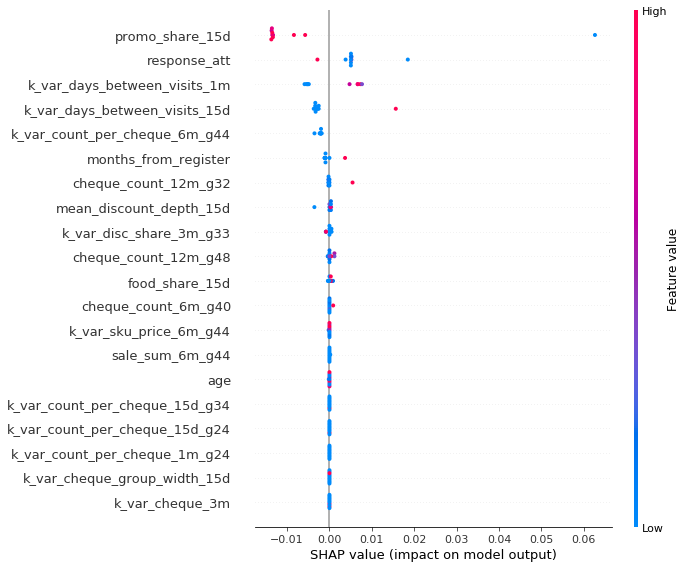

In [28]:
shap.initjs()
shap.summary_plot(shap_values, features=test[:10], feature_names=data.columns)

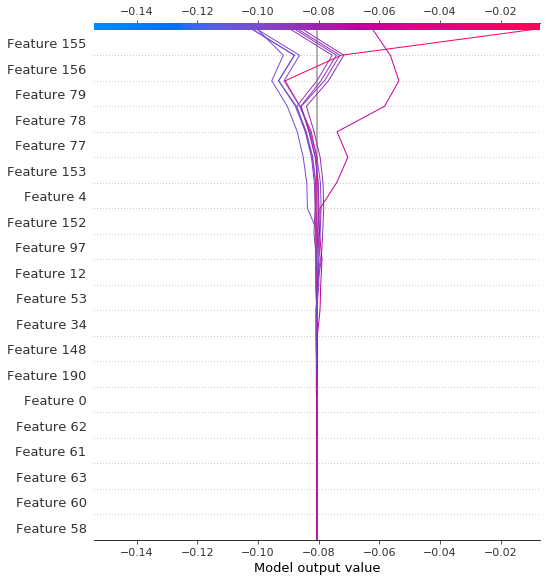

In [30]:
shap.initjs()
shap.decision_plot(explainer.expected_value, shap_values)